In [63]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [65]:
import numpy as np
import matplotlib.dates as mdates

In [66]:
df = pd.read_json("newsdata.json", lines=True)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [68]:
df['text'] = (
    df['headline'].fillna('') + ". " +
    df['short_description'].fillna('')
).str.strip()

In [69]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['time_bin'] = df['date'].dt.to_period('M').dt.to_timestamp()

df.head()

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
 6   text               209527 non-null  object        
 7   time_bin           209527 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(6)
memory usage: 12.8+ MB


In [71]:
df = df[df['text'].str.len() > 10].reset_index(drop=True) # filtering short texts in the dataset

In [72]:
df = df.head(25000)


In [73]:
df

,link,headline,category,short_description,authors,date,text,time_bin
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23,Over 4 Million Americans Roll Up Sleeves For O...,2022-09-01
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23,"American Airlines Flyer Charged, Banned For Li...",2022-09-01
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23,23 Of The Funniest Tweets About Cats And Dogs ...,2022-09-01
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23,The Funniest Tweets From Parents This Week (Se...,2022-09-01
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22,Woman Who Called Cops On Black Bird-Watcher Lo...,2022-09-01
...,...,...,...,...,...,...,...,...
24995,https://www.huffingtonpost.com/entry/student-p...,Student Protestors And Their Faculty Allies At...,COLLEGE,Four months have passed since the riots that b...,"Michael Zimmerman, ContributorFounder and Exec...",2017-09-17,Student Protestors And Their Faculty Allies At...,2017-09-01
24996,https://www.huffingtonpost.com/entry/a-classro...,A Classroom Of Tomorrow,EDUCATION,"Good morning, children, and welcome to today’s...","Peter Greene, ContributorTeacher, blogger, tai...",2017-09-17,"A Classroom Of Tomorrow. Good morning, childre...",2017-09-01
24997,https://www.huffingtonpost.com/entry/grindr-pr...,Watch What Happened When These Two Men Swapped...,QUEER VOICES,"""What The Flip?"" examines how racial stereotyp...",Curtis M. Wong,2017-09-17,Watch What Happened When These Two Men Swapped...,2017-09-01
24998,https://www.huffingtonpost.com/entry/hate-crim...,Exclusive: New Report Offers Proof Of US Hate ...,POLITICS,New data obtained by HuffPost shows hate crime...,Christopher Mathias,2017-09-17,Exclusive: New Report Offers Proof Of US Hate ...,2017-09-01


In [74]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")


In [ ]:
topic_model = BERTopic(embedding_model=embed_model, verbose=True)

texts = df['text'].tolist()
topics, probs = topic_model.fit_transform(texts)

2025-12-06 22:27:29,351 - BERTopic - Embedding - Transforming documents to embeddings.
Batches:   2%|▏         | 14/782 [00:03<03:11,  4.00it/s]

In [ ]:
df['topic'] = topics
df['topic_prob'] = probs

In [ ]:
topic_info = topic_model.get_topic_info()
valid_topics = topic_info[topic_info["Topic"] >= 0]["Topic"].tolist() #removing outlier topic

In [ ]:
topic_names = {}

for t in valid_topics:
    words = topic_model.get_topic(t)
    topic_names[t] = ", ".join([w[0] for w in words[:4]])  # top 5 words



In [ ]:
df["topic_name"] = df["topic"].map(topic_names)

df = df[df["topic"] != -1].reset_index(drop=True) #removing


In [ ]:
# Compute topic frequency (topic prevalence)
topics_over_time = (
    df.groupby(['time_bin', 'topic'])
      .size()
      .reset_index(name='Frequency')
)


In [ ]:


# Pivot table
pivot = topics_over_time.pivot_table(
    index='time_bin',
    columns='topic',
    values='Frequency',
    fill_value=0
).sort_index()




In [ ]:
# Remove topic -1 column if present
pivot = pivot.drop(columns=[-1], errors='ignore')

# Normalize to probabilities
pivot_norm = pivot.div(pivot.sum(axis=1), axis=0).fillna(0)






In [ ]:
rw = 3

# rolling mean (trailing). Use center=True if you prefer centered window.
rolling_mean = pivot_norm.rolling(window=rw, min_periods=1, center=False).mean()

# use ddof=0 to avoid NaNs for single-value windows; then clip tiny stds to a floor
rolling_std = pivot_norm.rolling(window=rw, min_periods=1, center=False).std(ddof=0)

# set a small floor to avoid huge z-scores from tiny std
std_floor = 1e-6
rolling_std = rolling_std.clip(lower=std_floor)

zscore = (pivot_norm - rolling_mean) / rolling_std
zscore = zscore.replace([np.inf, -np.inf], np.nan).fillna(0)


In [ ]:
#zscore = (pivot_norm - rolling_mean) / rolling_std
#zscore = zscore.fillna(0)

In [ ]:

topk = 6
# Select top-K topics (by total prevalence)
top_k_ids = pivot_norm.sum().sort_values(ascending=False).head(topk).index.tolist()

top_topics = [topic_names[t] for t in top_k_ids]



In [ ]:
# Save fitted BERTopic model, embeddings, and metadata
import os
import json
import numpy as np

os.makedirs("saved_trains", exist_ok=True)

# 1) (Re)compute embeddings once and save them
#    If you already computed embeddings separately, skip this encode step and save that array instead.
embeddings = embed_model.encode(texts, show_progress_bar=True, batch_size=64)
embeddings = embeddings.astype(np.float32)   # smaller on disk
np.save("saved_trains/embeddings.npy", embeddings)

# 2) Save the fitted BERTopic model (folder)
topic_model.save("saved_trains/bertopic_model")

# 3) Save topic names / labels and simple metadata
with open("saved_trains/topic_names.json", "w", encoding="utf-8") as f:
    json.dump(topic_names, f, ensure_ascii=False, indent=2)

metadata = {
    "embedding_model": "all-MiniLM-L6-v2",
    "n_documents": len(texts),
    "bertopic_version": topic_model.__version__ if hasattr(topic_model, "__version__") else None,
    "saved_at": pd.Timestamp.now().isoformat()
}
with open("saved_trains/metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Saved: saved_trains/embeddings.npy, saved_trains/bertopic_model/, saved_trains/topic_names.json, saved_trains/metadata.json")


Batches: 100%|██████████| 79/79 [00:30<00:00,  2.62it/s]
2025-12-06 22:22:24,756 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


Saved: saved_trains/embeddings.npy, saved_trains/bertopic_model/, saved_trains/topic_names.json, saved_trains/metadata.json


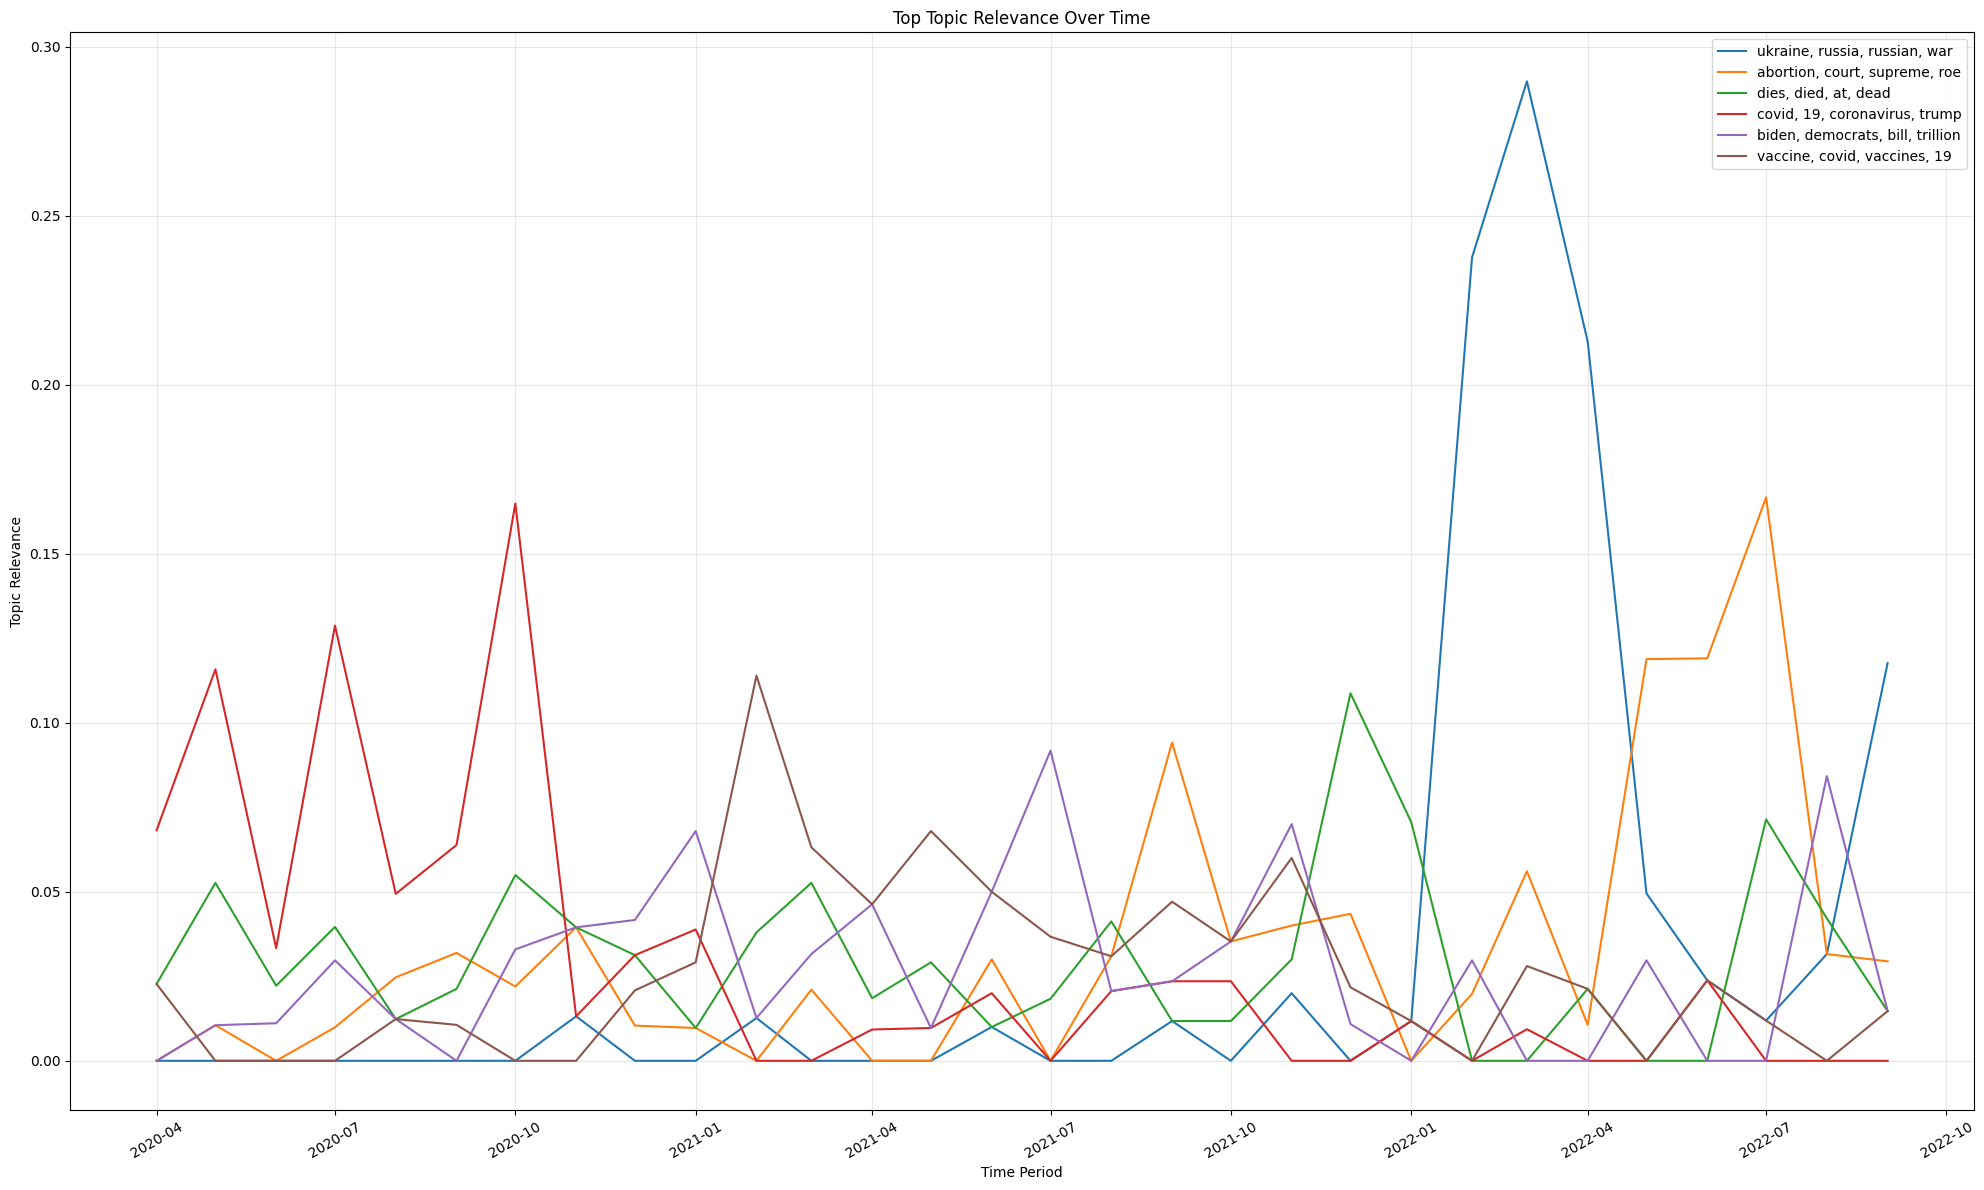

In [ ]:
plt.figure(figsize=(20,12))

for t in top_k_ids:
    label = topic_names[t]   
    plt.plot(pivot_norm.index, pivot_norm[t], label=label)

plt.xlabel("Time Period")
plt.ylabel("Topic Relevance")
plt.title("Top Topic Relevance Over Time")
plt.xticks(rotation=30)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


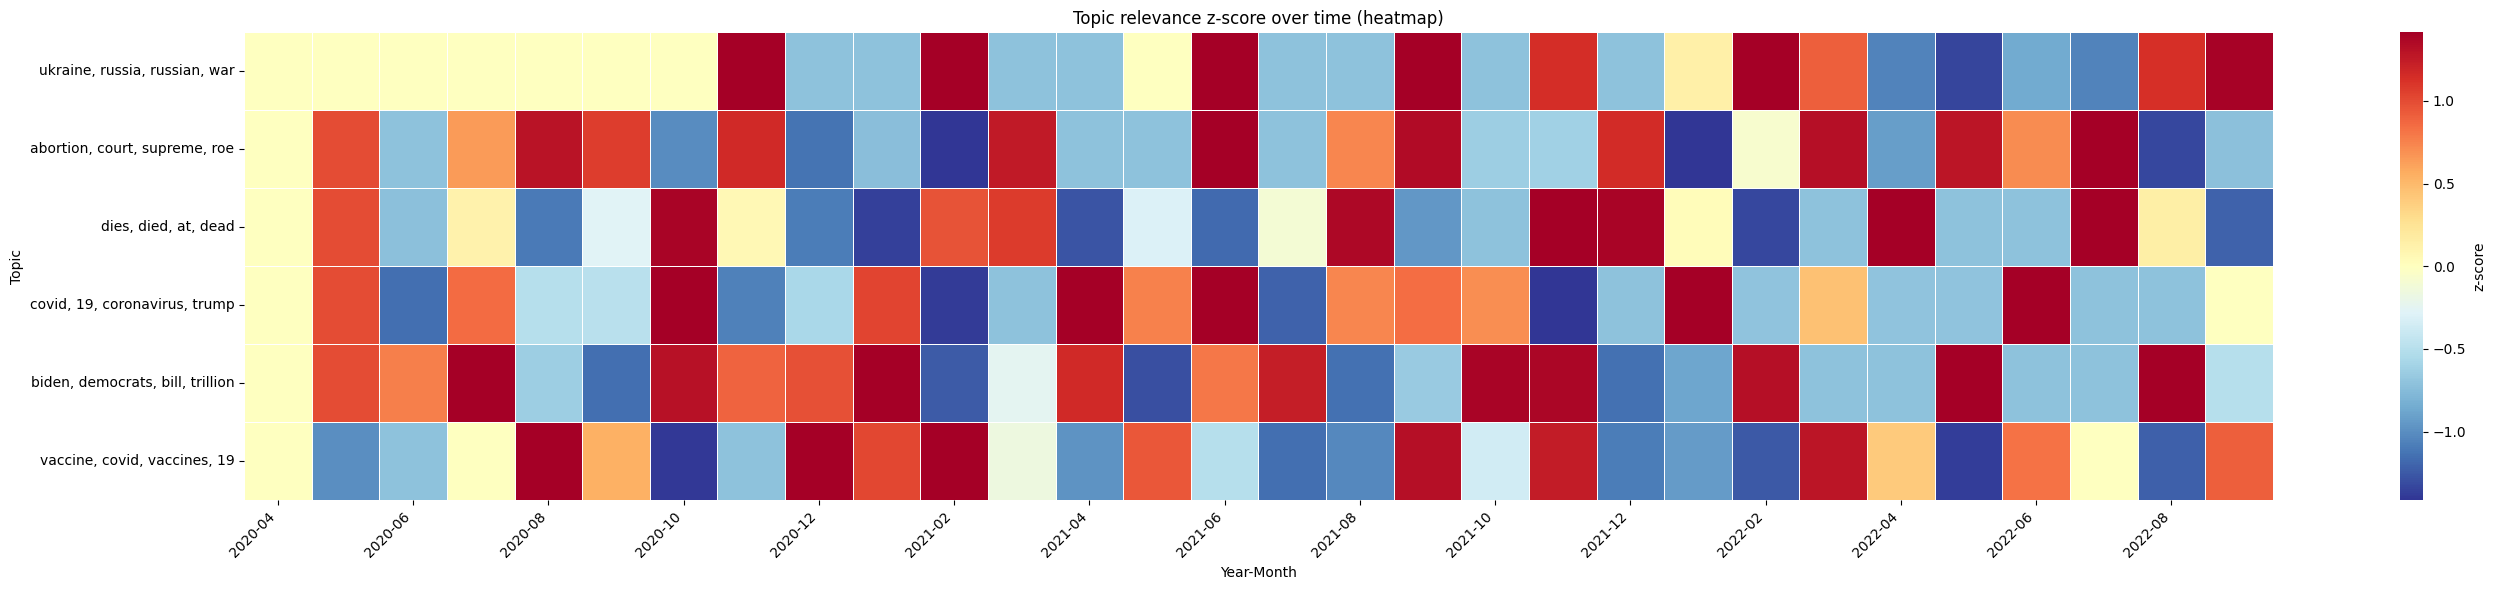

In [ ]:
# Cell: heatmap of z-scores for selected topics (top_k_ids -> readable names)


# Ensure topics exist in zscore
heat_ids = [t for t in top_k_ids if t in zscore.columns]
if not heat_ids:
    raise ValueError("None of the top_k_ids are present in the zscore DataFrame.")

# Build a DataFrame for the heatmap: rows = topics (readable names), cols = time bins
heat_df = zscore[heat_ids].T.copy()
heat_df.index = [topic_names[t] for t in heat_df.index]  # readable labels

plt.figure(figsize=(28, 6))
ax = sns.heatmap(heat_df, cmap='RdYlBu_r', center=0, cbar_kws={'label': 'z-score'}, linewidths=0.5, linecolor='white')

# Build Year-Month labels from the time index
time_bins = zscore.index.to_list()
labels = [d.strftime('%Y-%m') for d in time_bins]

# Reduce tick density (show at most ~12 ticks)
n_ticks = len(labels)
tick_step = max(1, n_ticks // 12)

# Set tick positions and labels (center ticks on cells)
ax.set_xticks(np.arange(0, n_ticks, tick_step) + 0.5)
ax.set_xticklabels([labels[i] for i in range(0, n_ticks, tick_step)], rotation=45, ha='right')

ax.set_xlabel('Year-Month')
ax.set_ylabel('Topic')
ax.set_title('Topic relevance z-score over time (heatmap)')
plt.tight_layout()
plt.show()
